In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import csv
from timeit import default_timer as timer
from pickle import dump

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

from hyperopt import STATUS_OK
from hyperopt import Trials, hp, tpe, fmin, space_eval
from hyperopt.pyll import scope
import warnings

warnings.filterwarnings("ignore")
import shap

**Lecture des donnees**

In [3]:
df = pd.read_csv('C:/Users/leila/data.csv.gz', compression='gzip')


In [4]:
df_class = df[df['TARGET'].notnull()].copy()
df_class.shape

(307507, 554)

**Reduction des variables**

importance des features avec 10% du df_class

In [5]:
df_class = df_class.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:

df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [7]:
df_red = df_class.sample(30000, random_state= 23).copy()
df_red.shape

(30000, 554)

In [8]:
# Collect features
feats = [
    f for f in df_red.columns if f not in
    ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
]

# Create dF with all features without TARGET
train_df = df_red[feats]


# Create dF TARGET
train_target = df_red[df_red['TARGET'].notnull()]['TARGET']

In [9]:
feature_importances = np.zeros(train_df.shape[1])


LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}
# Create the model with several hyperparameters
model = LGBMClassifier(**LIGHTGBM_PARAMS)

In [10]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = \
    train_test_split(train_df, train_target, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100,
              eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.737155	valid_0's binary_logloss: 0.26335
[400]	valid_0's auc: 0.746096	valid_0's binary_logloss: 0.256134
[600]	valid_0's auc: 0.749135	valid_0's binary_logloss: 0.253589
Early stopping, best iteration is:
[686]	valid_0's auc: 0.749548	valid_0's binary_logloss: 0.253057
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.743491	valid_0's binary_logloss: 0.263818
[400]	valid_0's auc: 0.749293	valid_0's binary_logloss: 0.256682
[600]	valid_0's auc: 0.753935	valid_0's binary_logloss: 0.25369
Early stopping, best iteration is:
[673]	valid_0's auc: 0.755211	valid_0's binary_logloss: 0.252998


In [11]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train_df.columns),
                                    'importance': feature_importances})\
.sort_values('importance', ascending = False)

In [12]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 170 features with 0.0 importance


,feature,importance
355,PREV_NAME_CASH_LOAN_PURPOSE_Refusaltonamethego...,0.0
358,PREV_NAME_CASH_LOAN_PURPOSE_Weddinggiftholiday...,0.0
361,PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,0.0
45,FLAG_DOCUMENT_7,0.0
94,NAME_HOUSING_TYPE_Coopapartment,0.0


In [91]:
med_features = list(feature_importances[feature_importances['importance'] >65.]['feature'])
print('There are %d features with importance > mean' % len(med_features))

There are 192 features with importance > mean


In [14]:
train_df = train_df.drop(columns = zero_features)

In [14]:
df = df.drop(columns = zero_features)
df.to_csv('df.csv')

In [22]:
train_df.to_csv('train_df.csv')
train_target.to_csv('train_target.csv')

In [15]:
train_df.shape

(30000, 382)

**Recherche des hyperparametres sur auc**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df,
                                                    train_target,
                                                    test_size=0.3, random_state=42)
train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)

In [17]:
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':100,
              'learning_rate':0.03,
              'metric':'auc',
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, train_data, nfold=5,
                       seed=6, stratified=True,
                       metrics=['auc'], return_cvbooster=True)
    return max(cv_result['auc-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)

In [18]:
lgbBO.maximize(init_points=2, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.53905080314

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

|  1        |  0.749    |  0.5391   |  3.576    |  1.808    |  7.18     |  24.06    |  0.06494  |  33.19    |
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] feature_fraction is set=0.8134184006256638, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8134184006256638
[LightGBM] [

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48054
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 382
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081190 -> initscore=-2.426281
[LightGBM] [Info] Start training from score -2.426281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l2 is set=2.1674963923113335, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1674963923113335
[LightGBM] [Warning] lambda_l1 is set=2.9699162251902895, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.9699162251902895
[LightGBM] [Warning] feature_fraction is set=0.894127419305972, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.894127419305972
[LightGBM] [Info] Number of positive: 1363, number of negative: 15437
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48054
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 382
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l2 is set=2.606420079691905, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.606420079691905
[LightGBM] [Warning] lambda_l1 is set=0.3582629301822182, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=0.3582629301822182
[LightGBM] [Warning] feature_fraction is set=0.5692832033339715, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5692832033339715
[LightGBM] [Info] Number of positive: 1363, number of negative: 15437
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48054
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 382
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  4        |  0.7483   |  0.5693   |  0.3583   |  2.606    |  5.331    |  37.77    |  0.06703  |  25.43    |
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598

[LightGBM] [Warning] lambda_l2 is set=1.3256213372319718, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.3256213372319718
[LightGBM] [Warning] lambda_l1 is set=2.987049058684822, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.987049058684822
[LightGBM] [Warning] feature_fraction is set=0.28912212603432275, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.28912212603432275
[LightGBM] [Info] Number of positive: 1363, number of negative: 15437
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48054
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 382
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.575946831862097

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [19]:
lgbBO.max

{'target': 0.7523598413287221,
 'params': {'feature_fraction': 0.28912212603432275,
  'lambda_l1': 2.987049058684822,
  'lambda_l2': 1.3256213372319718,
  'max_depth': 5.00958506102633,
  'min_child_weight': 36.43107902211796,
  'min_split_gain': 0.0210327811384753,
  'num_leaves': 34.00377941024376}}

In [20]:
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df = pd.DataFrame()

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            colsample_bytree=0.9497036,
            feature_fraction=0.29,
            lambda_l1=2.99,
            lambda_l2=1.321,
            learning_rate=0.03,
            max_depth=5,
            min_child_weight=36.43107902211796,
            min_split_gain=0.0210327811384753,
            num_leaves=34,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=-1,
            subsample=0.8715623,
            verbose=-1, )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train[val_idx] = clf.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test += clf.predict_proba(X_test[feats],
                                  num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_train, pred_train))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.29, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.29
[LightGBM] [Warning] lambda_l1 is set=2.99, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.99
[LightGBM] [Warning] lambda_l2 is set=1.321, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.321
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	training's auc: 0.805218	training's binary_logloss: 0.257824	valid_1's auc: 0.726934	valid_1's binary_logloss: 0.265751

 Fold  1 AUC : 0.726934
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.29, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.29
[LightGBM] [Warning] lambda_l1 is set

In [21]:
roc_auc_score(y_test, pred_test)

0.7664707508270427

In [22]:
roc_auc_score(y_train, pred_train)

0.7427151702364547

In [23]:
def plt_confusion_matrix(y_true, y_pred):
    '''fonction qui trace la matrice de confusion'''
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="YlGnBu")
    plt.ylabel('True classes', fontsize=14)
    plt.xlabel('Predicted classes', fontsize=14)
    plt.title('Matrice de confusion', fontsize=20)
    print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     19296
         1.0       0.88      0.01      0.02      1704

    accuracy                           0.92     21000
   macro avg       0.90      0.51      0.49     21000
weighted avg       0.92      0.92      0.88     21000



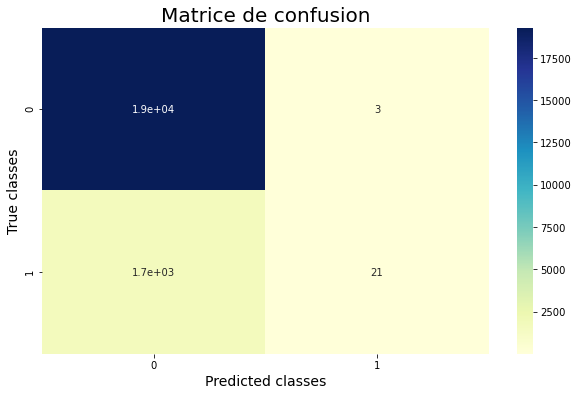

In [24]:
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['predicted_class'] = clf.predict(X_train[feats])
pred_train_df['TARGET'] = y_train
plt_confusion_matrix(pred_train_df['TARGET'], pred_train_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8278
         1.0       0.20      0.00      0.00       722

    accuracy                           0.92      9000
   macro avg       0.56      0.50      0.48      9000
weighted avg       0.86      0.92      0.88      9000



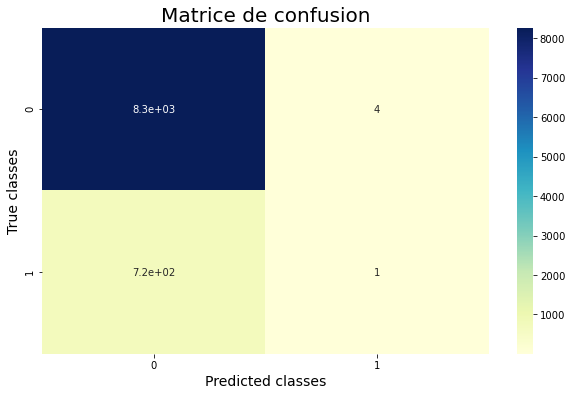

In [25]:
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['TARGET'] = y_test
pred_test_df['predicted_class'] = clf.predict(X_test[feats])
plt_confusion_matrix(pred_test_df['TARGET'], pred_test_df['predicted_class'])

In [26]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby(
        "feature").mean().sort_values(
            by="importance", ascending=False)[:20].index

    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    

def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6, 6))
    scores = []
    for n_fold, (_, val_idx) in enumerate(folds_idx_):
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

    plt.plot([0, 1], [0, 1],
             linestyle='--',
             lw=2,
             color='r',
             label='Luck',
             alpha=.8)
    
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr,tpr,color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()


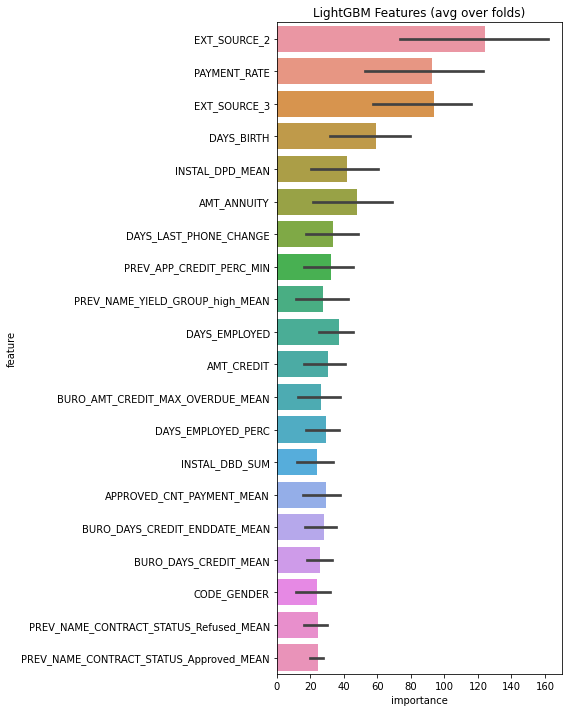

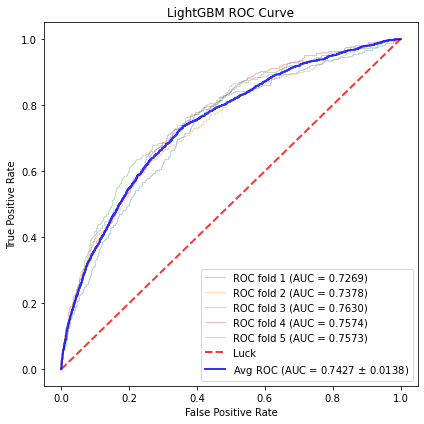

In [27]:
folds_idx = [(trn_idx, val_idx)
                 for trn_idx, val_idx in folds.split(X_train, y_train)]
display_importances(feature_importance_df_=feature_importance_df)
display_roc_curve(y_=y_train, oof_preds_=pred_train, folds_idx_=folds_idx)

In [28]:
model = clf
X = X_train[feat_selec]
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

100%|===================| 20925/21000 [01:41<00:00]        

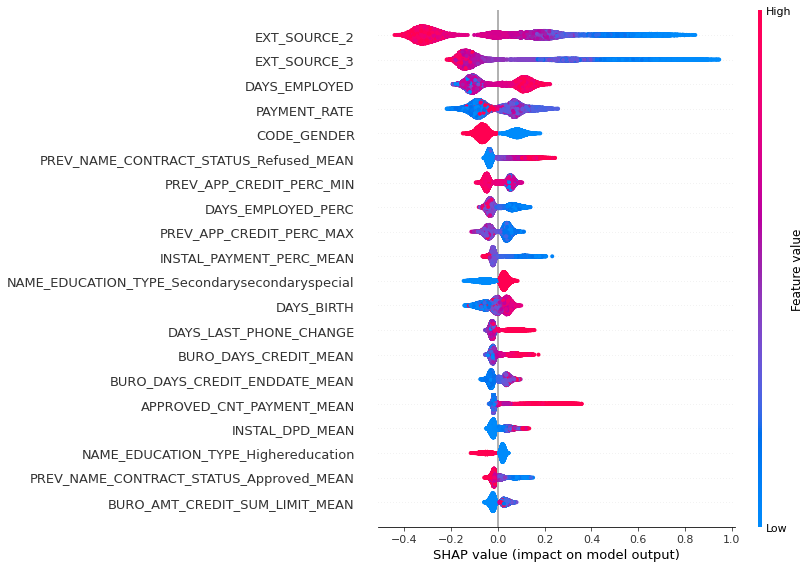

In [31]:
shap.summary_plot(shap_values, X[feats])

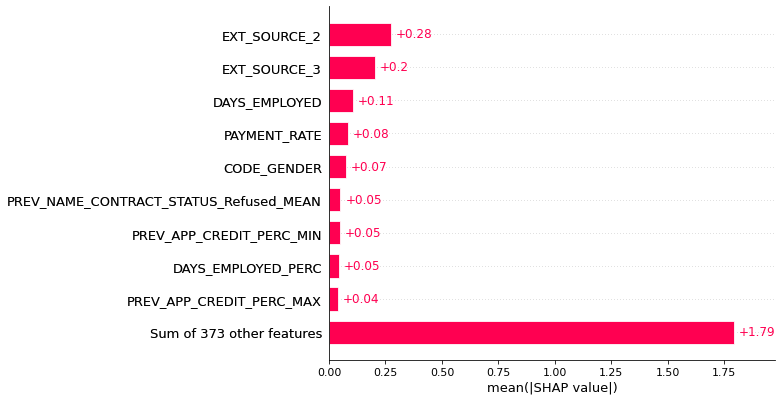

In [32]:
shap.plots.bar(shap_values)



**Undersampling**

A priori plus adapte pour eviter l'overfitting

In [33]:
imp_feat = feature_importance_df[["feature", "importance"]].groupby(
        "feature").mean().sort_values(by="importance", ascending=False)

feat_selec = list(imp_feat[imp_feat['importance']>7.].index)
len(feat_selec)


151

In [34]:
from imblearn.under_sampling import RandomUnderSampler

rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train[feat_selec], y_train)

pred_train_ru = np.zeros(X_ru.shape[0])
pred_test_ru = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_ru = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_ru = LGBMClassifier(
            colsample_bytree=0.9497036,
            feature_fraction=0.29,
            lambda_l1=2.99,
            lambda_l2=1.321,
            learning_rate=0.03,
            max_depth=5,
            min_child_weight=36.43107902211796,
            min_split_gain=0.0210327811384753,
            num_leaves=34,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=-1,
            subsample=0.8715623,
            verbose=-1, )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_ru.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train_ru[val_idx] = clf_ru.predict_proba(val_x,
                                                  num_iteration=clf_ru.best_iteration_)[:, 1]
    pred_test_ru += clf_ru.predict_proba(X_test[feats],
                                         num_iteration=clf_ru.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_ru = pd.DataFrame()
    fold_importance_df_ru["feature"] = feats
    fold_importance_df_ru["importance"] = clf_ru.feature_importances_
    fold_importance_df_ru["fold"] = n_fold + 1
    feature_importance_df_ru = pd.concat([feature_importance_df_ru, fold_importance_df_ru], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ru[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_ru, pred_train_ru))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.29, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.29
[LightGBM] [Warning] lambda_l1 is set=2.99, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.99
[LightGBM] [Warning] lambda_l2 is set=1.321, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.321
Training until validation scores don't improve for 30 rounds
[100]	training's auc: 0.842429	training's binary_logloss: 0.551367	valid_1's auc: 0.752789	valid_1's binary_logloss: 0.600474
[200]	training's auc: 0.874007	training's binary_logloss: 0.49839	valid_1's auc: 0.761423	valid_1's binary_logloss: 0.58265
Early stopping, best iteration is:
[209]	training's auc: 0.876134	training's binary_logloss: 0.494968	valid_1's auc: 0.762377	valid_1's binary_logloss: 0.581715

 Fold  1 AUC : 0.762377
[LightGBM] [Warning] num_thread

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76      1704
         1.0       0.76      0.76      0.76      1704

    accuracy                           0.76      3408
   macro avg       0.76      0.76      0.76      3408
weighted avg       0.76      0.76      0.76      3408



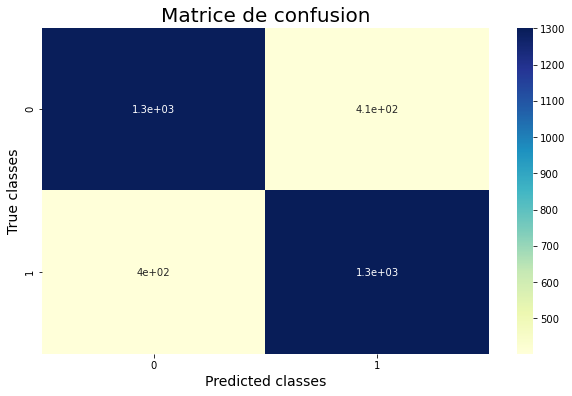

In [35]:
pred_train_ru_df = pd.DataFrame(index=X_ru.index)
pred_train_ru_df['predicted_class'] = clf_ru.predict(X_ru[feat_selec])
pred_train_ru_df['TARGET'] = y_ru
plt_confusion_matrix(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      8278
         1.0       0.16      0.70      0.26       722

    accuracy                           0.68      9000
   macro avg       0.56      0.69      0.53      9000
weighted avg       0.90      0.68      0.75      9000



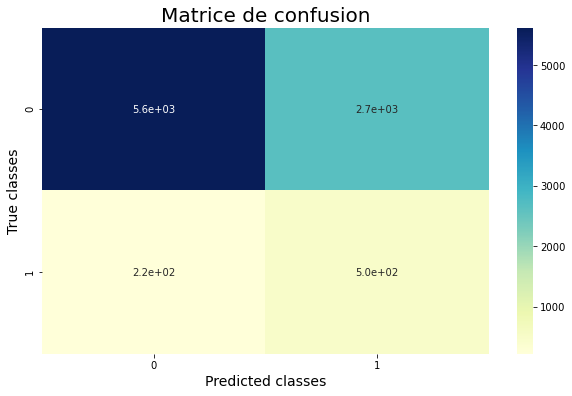

In [36]:
pred_test_ru_df = pd.DataFrame(index=X_test.index)
pred_test_ru_df['TARGET'] = y_test
pred_test_ru_df['predicted_class'] = clf_ru.predict(X_test[feat_selec])
plt_confusion_matrix(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

**Changement de metrique**

recherche du meilleur model pour une metrique adapte au probleme

In [37]:
def eval_metric_custom(y_true, y_pred):
    
    TP_value = 0
    # on prédit des difficultés et il y en a -> on a raison, pas d'impact
    
    FP_value = 0
    # on prévoit des difficultés mais il n'y en a pas -> pas d'impact pour la banque
    # le manque à gagner et comblé par le modèle, si on passe de FP à TN, on passe de 0 à 1
    
    TN_value = 1
    # On prévoit que tout se passe bien et c'est le cas -> meilleure configuration
    
    FN_value = -10
    # on prévoit que tout se passe bien et il y a des difficultés de paiement
    # -> à éviter au maximum
    
    score_final = 0 # on initialise le score à 0
        
    for proba in np.linspace(0.01,0.3,100):  # on teste le seuil de probabilité
        y_pred_proba = np.array(y_pred)
        
        for i in range(y_pred_proba.shape[0]):
        
            # convert probability to label with threshold 'proba'
            if y_pred_proba[i]<proba:
                y_pred_proba[i] = 0
            else:
                y_pred_proba[i] = 1
    
        conf_matrix = confusion_matrix(y_true, y_pred_proba)
        
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]
        tp = conf_matrix[1, 1]
    
        gain = tn*TN_value + fp*FP_value + fn*FN_value + tp*TP_value
    
        perfect_model = (tn + fp)*TN_value + (fn + tp)*TP_value
        # modèle parfait qui prédit les vraies classes
    
        no_model = (tn + fp)*TN_value + (tp + fn)*FN_value
        # modèle qui prédit toujours 0
    
        score = (gain - no_model) / (perfect_model - no_model)
        # on normalise le gain : score de 1 pour un modèle parfait 
        # et 0 pour un modèle qui dit toujours non
        
        if score > score_final:
            score_final = score
            threshold = proba
    
    print('seuil pour maximiser les profits :{}'.format(threshold))
    
    return 'score', score_final, True

In [38]:
eval_metric_custom(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

seuil pour maximiser les profits :0.01


('score', 0.7402582159624413, True)

In [39]:
eval_metric_custom(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

seuil pour maximiser les profits :0.01


('score', 0.33102493074792244, True)

In [40]:
def feval_metric_custom(preds, train_data):
    
    y_true = train_data.get_label()
    y_pred = preds
    
    eval_name, eval_result, is_higher_better = eval_metric_custom(y_true, y_pred)
    
    return eval_name, eval_result, is_higher_better

In [41]:
train_df = df_class[feat_selec]
train_target = df_class['TARGET']

In [42]:
train_df.shape

(307507, 151)

In [39]:
train_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,0.018801,-9461.0,-637.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,0.003541,-16765.0,-1188.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,0.010032,-19046.0,-225.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,0.008019,-19005.0,-3039.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,0.028663,-19932.0,-3038.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_df,
                                                    train_target,
                                                    test_size=0.3, random_state=42)
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

In [44]:
# prepare data
ru_data = lgb.Dataset(data=X_ru, label=y_ru, free_raw_data=False)

# parameters
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':30,
              'learning_rate':0.03,
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, ru_data, nfold=5,
                       seed=6,verbose_eval =200,
                       feval=feval_metric_custom,
                       return_cvbooster=True)
    print(cv_result)
    return max(cv_result['score-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO_ru = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)

In [45]:
# optimize
lgbBO_ru.maximize(init_points=2, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.53905080314

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.25313131

seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0

seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0

seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.11252525252525251
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.13303030303030303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.11252525252525251
seuil p

seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.12717171717171716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10666666666666666
seuil pour maximiser les profits :0.10080808080808079
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.13595959595959595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10666666666666666
seuil pour maximiser les profits :0.10080808080808079
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser le

seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.09494949494949494
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11838383838383837
seuil pour maximiser les profits :0.10080808080808079
seuil pour maximiser les profits :0.09494949494949494
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.11838383838383837
seuil pour maximiser les profits :0.09787878787878787
seuil pour maximiser les profits :0.09494949494949494
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.11838383838383837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.09787878787878787
seuil pour maximiser les profits :0.09494949494949494
seuil p

seuil pour maximiser les profits :0.08909090909090908
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1213131313131313
{'binary_logloss-mean': [0.6891304684482742, 0.6861493045141837, 0.6841101679643022, 0.6821001240614587, 0.6793169329983798, 0.6766231166641461, 0.674060307308729, 0.6714832719059414, 0.6684077460162927, 0.6661097628660286, 0.6632491997601975, 0.6611468684103892, 0.6585601365859965, 0.6565644241673831, 0.6541123686572151, 0.6518635700724206, 0.6506092687532599, 0.6485498014079435, 0.646520665731502, 0.6446126340970413, 0.6431280213810597, 0.6413981373715497, 0.6400661652566111, 0.638434916041122, 0.6372750609075932, 0.6357507296663809, 0.6344484014274652, 0.6330025480489836, 0.6317230409886089, 0.6303992288763428, 0.6290917535492418, 0.6279002192209745, 0.6267249311971889, 0.6258893398211014, 0.6249553734490192, 0.6240551342410822, 0.6231978670441842, 0.6221631161300016, 0.62

[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] feature_fraction is set=0.8134184006256638, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8134184006256638
[LightGBM] [Info] Number of positive: 13907, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31120
[LightGBM] [Info] Number of data points in the train set: 27813, number of used features: 151
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, 

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.15

seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :

[LightGBM] [Info] Total Bins 31120
[LightGBM] [Info] Number of data points in the train set: 27812, number of used features: 151
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.539050

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profit

seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :

seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits

[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.1076739957469837, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.1076739957469837
[LightGBM] [Warning] lambda_l1 is set=3.0317053220486354, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.0317053220486354
[LightGBM] [Warning] feature_fraction is set=0.5444570573181484, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5444570573181484
[LightGBM] [Info] Number of positive: 13907, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise mul

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2912121212121212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.28828282828282825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2677777777777778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.258989898989899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.24141414141414141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.23848484848484847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.22676767676767676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.2209090909090909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.20626262626262626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=2.4148610299103694, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.4148610299103694
[LightGBM] [Warning] lambda_l1 is set=3.3067342543331364, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.3067342543331364
[LightGBM] [Warning] feature_fraction is set=0.722224619977795, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.722224619977795
[LightGBM] [Info] Number of positive: 13907, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise multi

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2443

seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :

In [46]:
lgbBO_ru.max

{'target': 0.9014956645892305,
 'params': {'feature_fraction': 0.5390508031418598,
  'lambda_l1': 3.5759468318620975,
  'lambda_l2': 1.8082901282149315,
  'max_depth': 7.179532731987587,
  'min_child_weight': 24.064465970250712,
  'min_split_gain': 0.06494351719359896,
  'num_leaves': 33.18933143651654}}

In [47]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_cm_final = np.zeros(X_ru.shape[0])
pred_test_cm_final = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_cm_final = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_cm_final = LGBMClassifier(
                colsample_bytree=0.9497036,
                feature_fraction=0.54,
                lambda_l1=3.5759468318620975,
                lambda_l2=1.8082901282149315,
                learning_rate=0.03,
                max_depth=7,
                min_child_weight=24.064465970250712,
                min_split_gain=0.06494351719359896,
                num_leaves=38,
                nthread=4,
                n_estimators=10000,
                objective='binary',
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                silent=-1,
                subsample=0.8715623,
                verbose=-1 )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_cm_final.fit(trn_x, trn_y,
                     eval_set=[(trn_x, trn_y), (val_x, val_y)],
                     eval_metric=eval_metric_custom,
                     verbose=100,
                     early_stopping_rounds=30
                     )

    pred_train_cm_final[val_idx] = clf_cm_final.predict_proba(val_x,
                                                              num_iteration=clf_cm_final.best_iteration_)[:,1] / folds.n_splits
    pred_test_cm_final += clf_cm_final.predict_proba(X_test[feats],
                                                     num_iteration=clf_cm_final.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_cm_final = pd.DataFrame()
    fold_importance_df_cm_final["feature"] = feats
    fold_importance_df_cm_final["importance"] = clf_cm_final.feature_importances_
    fold_importance_df_cm_final["fold"] = n_fold + 1
    feature_importance_df_cm_final = pd.concat([feature_importance_df_cm_final,
                                                fold_importance_df_cm_final], axis=0)


    eval_name, eval_result, is_higher_better = eval_metric_custom(val_y, pred_train_cm_final[val_idx])
    
    print('\n Fold %2d score : %.6f' %
              (n_fold + 1, eval_result))
    del trn_x, trn_y, val_x, val_y, eval_name, eval_result, is_higher_better

eval_name, eval_result, is_higher_better = eval_metric_custom(y_ru, pred_train_cm_final)
print('\n Full score %.6f' % eval_result)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.54, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.54
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
Training until validation scores don't improve for 30 rounds
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser le

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profit

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximi

In [48]:
filename = 'LightGBMModel2.pkl'
outfile = open(filename,'wb')
dump(clf_cm_final, outfile)
outfile.close()

              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70     17383
         1.0       0.70      0.71      0.71     17383

    accuracy                           0.71     34766
   macro avg       0.71      0.71      0.71     34766
weighted avg       0.71      0.71      0.71     34766



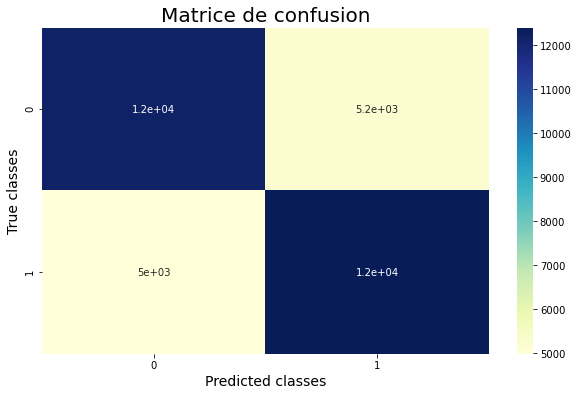

In [49]:
pred_train_cm_final_df = pd.DataFrame(index=X_ru.index)
pred_train_cm_final_df['predicted_class'] = clf_cm_final.predict(X_ru)
pred_train_cm_final_df['TARGET'] = y_ru
plt_confusion_matrix(pred_train_cm_final_df['TARGET'], pred_train_cm_final_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     84811
         1.0       0.16      0.69      0.26      7442

    accuracy                           0.68     92253
   macro avg       0.56      0.68      0.53     92253
weighted avg       0.90      0.68      0.75     92253



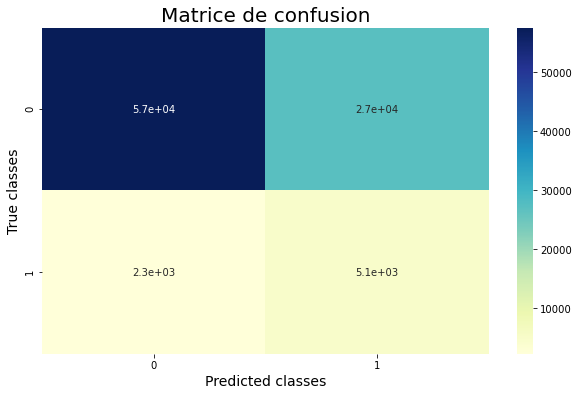

In [50]:
pred_test_cm_final_df = pd.DataFrame(index=X_test.index)
pred_test_cm_final_df['TARGET'] = y_test
pred_test_cm_final_df['predicted_class'] = clf_cm_final.predict(X_test[feat_selec])
plt_confusion_matrix(pred_test_cm_final_df['TARGET'], pred_test_cm_final_df['predicted_class'])

In [53]:
trains, tests = train_test_split(df_class.set_index('SK_ID_CURR'),
                               test_size=0.3, stratify=df_class.set_index('SK_ID_CURR').TARGET)

<AxesSubplot:title={'center':'Verify that class distributuion in train is same as input data'}, xlabel='TARGET'>

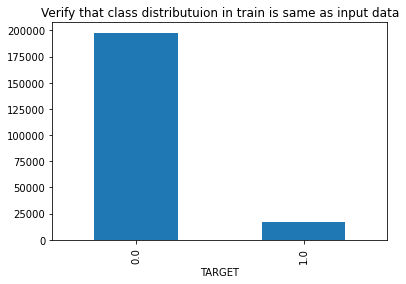

In [54]:
trains.pivot_table(index='TARGET', aggfunc='size').plot(kind='bar',
                                                    title='Verify that class distributuion in train is same as input data')

<AxesSubplot:title={'center':'Verify that class distributuion in train is same as input data'}, xlabel='TARGET'>

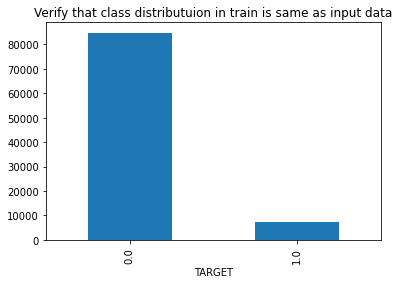

In [55]:
tests.pivot_table(index='TARGET', aggfunc='size').plot(kind='bar',
                                                    title='Verify that class distributuion in train is same as input data')

In [56]:
cat_cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']
num_cols = [col for col in feat_selec if col not in cat_cols]

In [57]:
std = StandardScaler()
X_tr_std =  pd.DataFrame(std.fit_transform(trains[num_cols]),
                       index = trains.index,
                       columns = num_cols)
for col in cat_cols :
    X_tr_std[col] = trains[col].values

In [58]:
X_te_std =  pd.DataFrame(std.fit_transform(tests[num_cols]),
                       index = tests.index,
                       columns = num_cols)
for col in cat_cols :
    X_te_std[col] = tests[col].values

In [59]:
def missing_values(data, plot=False):
    '''Missing Value'''
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    return mst

In [60]:
mst = missing_values(X_tr_std, plot=False)
len(mst[mst['Num_Missing']>0])
col_miss = list(mst[mst['Num_Missing']>0].index)
col_miss

[]

In [61]:
mste = missing_values(X_te_std, plot=False)
len(mste[mste['Num_Missing']>0])
col_misse = list(mste[mste['Num_Missing']>0].index)
col_misse

[]

In [62]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', k_neighbors=5,
           n_jobs=-1, random_state=14) #'minority'

# NB: SMOTE works only on encoded data
X_tr_sm, y_tr_sm = sm.fit_resample(X_tr_std, y_train)

In [63]:
X_tr_sm.shape

(395742, 152)

In [99]:
temp = X_tr_sm.copy()
temp['TARGET'] = y_tr_sm
red_df0 = temp[temp['TARGET']==0.].sample(50000)
red_df1 = temp[temp['TARGET']==1.].sample(50000)

In [100]:
red_df = pd.concat([red_df0, red_df1], axis=0)


In [101]:
red_df.sort_index(axis=0,inplace=True)
X_red_sm = red_df.drop('TARGET',axis=1)
y_red_sm = red_df['TARGET']

<AxesSubplot:title={'center':'Verify that class distributuion in train is same as input data'}, xlabel='TARGET'>

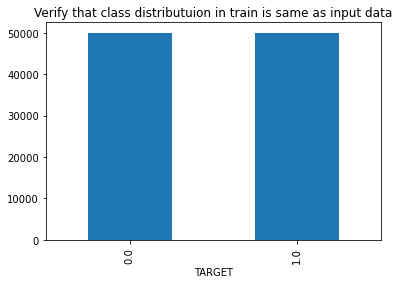

In [102]:
red_df.pivot_table(index='TARGET', aggfunc='size').plot(kind='bar',
                                                    title='Verify that class distributuion in train is same as input data')

In [103]:
# prepare data
sm_data = lgb.Dataset(data=X_red_sm, label=y_red_sm, free_raw_data=False)

# parameters
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':30,
              'learning_rate':0.03,
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, sm_data, nfold=5,
                       seed=6,verbose_eval =200,
                       feval=feval_metric_custom,
                       return_cvbooster=True)
    print(cv_result)
    return max(cv_result['score-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO_sm = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)

In [104]:
# optimize
lgbBO_sm.maximize(init_points=2, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.53905080314

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser l

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les pro

seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.20626262626262626
[LightGBM] [Warning] No further

seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser

seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2209090909090909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les p

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.18575757575757576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.244343434343434

seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.1916161616161616
[200]	cv_agg's binary_logloss: 0.201241 + 0.00455409	cv_agg's score: 0.912118 + 0.00281657
seuil pour maximiser les profits :0.2736363636363636
s

seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.17404040404040405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les pr

seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.19747474747474747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximi

seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.17696969696969697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2648484848

seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.20919191919191918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maxi

seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.20626262626262626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser le

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser le

seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.1828282828282828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.223838383838

seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] 

seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.1593939393939394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.18868686868686868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser le

seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No f

seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1593939393939394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1593939393939394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1623232323232323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.1593939393939394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.23555555555555555
seuil po

[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] feature_fraction is set=0.8134184006256638, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8134184006256638
[LightGBM] [Info] Number of positive: 40000, number of negative: 40000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38743
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 152
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, 

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.2619191919191919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.264848484

seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2707070707070707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.2707070707070707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.2677777777

seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser l

seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1798989898

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.19454545454545455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.19454545454545455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.18575757575757576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.18575757575757576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.17404040404040405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.17404040404040405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.3
seuil pour maximiser l

seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.16525252525252526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.1447474747

seuil pour maximiser les profits :0.15353535353535352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.1535353535

seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.24141414141414141
seuil pour ma

seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.1476767676

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.19747474747474747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximis

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser le

seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704


seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.11838383838383837
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.21212121212121213
seuil pour ma

[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=2.1674963923113335, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1674963923113335
[LightGBM] [Warning] lambda_l1 is set=2.9699162251902895, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.9699162251902895
[LightGBM] [Warning] feature_fraction is set=0.894127419305972, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.894127419305972
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current val

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38743
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 152
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:Bo

seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.297

seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :

seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.24141414141414141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.24141414141414141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2414141

seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.223

seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.21212121212121213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with po

seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.223838

seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.2004040404040404
[200]	cv_agg's binary_logloss: 0.215069 + 0.00316131	cv_agg's score: 0.911566 + 0.00269891
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.1

seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.18868686868686868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24727272727272726
seuil pour maxim

seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.2004040404040404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.1798989898989899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.1798989898989899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.16818181818181818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.16818181818181818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour ma

seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.15353535353535352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.28535353535353536
seuil pour 

seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.15353535353535352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.15353535353535352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.15353535353535352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser l

seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.15646464646464647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les

seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.15646464646464647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.15646464646464647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.15646464646464647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29414141414141415
seuil pour maxi

seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No further splits with p

seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.1593939393939394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1301010101010

[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=0.8696863965780759, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=0.8696863965780759
[LightGBM] [Warning] lambda_l1 is set=2.883483055394972, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.883483055394972
[LightGBM] [Warning] feature_fraction is set=0.12324687703571043, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.12324687703571043
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil 

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070

seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.297070707070

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.2912121212121212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.28828282828282825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29707070707070704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2824242424242424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.273636363

seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2912121212121212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.27656565656565657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2707070707070707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2677777777777778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

seuil pour maximiser les profits :0.2502020202020202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.29707070707070704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.24434343434343433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.24434343434343433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2502020202020202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2502020202020202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2531313131313131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.23262626262626263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.25606060606060604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.24434343434343433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.24141414141414141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.23848484848484847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.23262626262626263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.22969696969696968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.22676767676767676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.22676767676767676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2209090909090909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2209090909090909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.3256213372319718, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.3256213372319718
[LightGBM] [Warning] lambda_l1 is set=2.987049058684822, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.987049058684822
[LightGBM] [Warning] feature_fraction is set=0.28912212603432275, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.28912212603432275
[LightGBM] [Info] Number of positive: 40000, number of negative: 40000
[LightGBM] [Warning] Auto-choosing col-wise mul

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2912121212121212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.28535353535353536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.24727272727272726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.24434343434343433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.20919191919191918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.22969696969696968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.2736363636363636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.2707070707070707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.258989898989899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2502020202020202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.23848484848484847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.23262626262626263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.22676767676767676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.22676767676767676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.20919191919191918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.20919191919191918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.23555555555555555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.21505050505050505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.21212121212121213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.20626262626262626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.19454545454545455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.18575757575757576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.23555555555555555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.23262626262626263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23262626262626263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.23262626262626263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

seuil pour maximiser les profits :0.2531313131313131
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.20333333333333334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.2004040404040404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.19454545454545455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.19454545454545455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2004040404040404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.19747474747474747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.1916161616161616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.19454545454545455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [105]:
lgbBO_sm.max

{'target': 0.913538,
 'params': {'feature_fraction': 0.8134184006256638,
  'lambda_l1': 4.818313802505147,
  'lambda_l2': 1.150324556477333,
  'max_depth': 8.166900152330658,
  'min_child_weight': 28.800271388880702,
  'min_split_gain': 0.0572364115482993,
  'num_leaves': 43.43752940414588}}

In [107]:
pred_train_sm = np.zeros(X_red_sm.shape[0])
pred_test_sm = np.zeros(X_te_std.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_sm = pd.DataFrame()

feats = [f for f in X_red_sm.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_sm = LGBMClassifier(
                colsample_bytree=0.9497036,
                feature_fraction=0.81,
                lambda_l1= 4.818313802505147,
                lambda_l2=1.150324556477333,
                learning_rate=0.03,
                max_depth=8,
                min_child_weight=28.800271388880702,
                min_split_gain=00.0572364115482993,
                num_leaves=43,
                nthread=4,
                n_estimators=10000,
                objective='binary',
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                silent=-1,
                subsample=0.8715623,
                verbose=-1 )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_red_sm, y_red_sm)):
    trn_x, trn_y = X_red_sm[feats].iloc[trn_idx], y_red_sm.iloc[trn_idx]
    val_x, val_y = X_red_sm[feats].iloc[val_idx], y_red_sm.iloc[val_idx]

    clf_sm.fit(trn_x, trn_y,
                     eval_set=[(trn_x, trn_y), (val_x, val_y)],
                     eval_metric=eval_metric_custom,
                     verbose=100,
                     early_stopping_rounds=30
                     )

    pred_train_sm[val_idx] = clf_sm.predict_proba(val_x,
                                                num_iteration=clf_sm.best_iteration_)[:,1] / folds.n_splits
    pred_test_sm += clf_sm.predict_proba(X_te_std[feats],
                                                     num_iteration=clf_sm.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_sm = pd.DataFrame()
    fold_importance_df_sm["feature"] = feats
    fold_importance_df_sm["importance"] = clf_sm.feature_importances_
    fold_importance_df_sm["fold"] = n_fold + 1
    feature_importance_df_sm = pd.concat([feature_importance_df_sm,
                                                fold_importance_df_sm], axis=0)


    eval_name, eval_result, is_higher_better = eval_metric_custom(val_y, pred_train_sm[val_idx])
    
    print('\n Fold %2d score : %.6f' %
              (n_fold + 1, eval_result))
    del trn_x, trn_y, val_x, val_y, eval_name, eval_result, is_higher_better

evalsm_name, evalsm_result, is_higher_better = eval_metric_custom(y_red_sm, pred_train_sm)
print('\n Full score %.6f' % evalsm_result)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
Training until validation scores don't improve for 30 rounds
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les pr

seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les prof

seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.156464

seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profit

seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits

seuil pour maximiser les profits :0.1916161616161616
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.199588	training's score: 0.920952	valid_1's binary_logloss: 0.205822	valid_1's score: 0.91339
seuil pour maximiser les profits :0.04515151515151515

 Fold  2 score : 0.912900
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
Training until validation scores don't improve for 30 rounds
seuil pour maximiser les profits :0.01
se

seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits

seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19

seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les prof

seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les prof

seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0

seuil pour maximiser les profits :0.03929292929292929

 Fold  5 score : 0.911030
seuil pour maximiser les profits :0.05686868686868687

 Full score 0.909834


In [108]:
filename = 'LightGBMModelsm.pkl'
outfile = open(filename,'wb')
dump(clf_sm, outfile)
outfile.close()

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     50000
         1.0       1.00      0.90      0.95     50000

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000



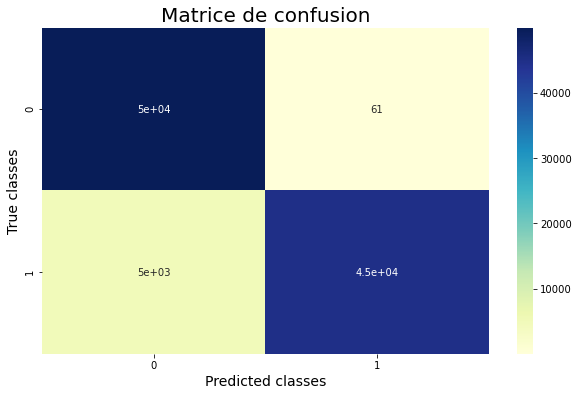

In [109]:
pred_train_sm_df = pd.DataFrame(index=X_red_sm.index)
pred_train_sm_df['predicted_class'] = clf_sm.predict(X_red_sm)
pred_train_sm_df['TARGET'] = y_red_sm
plt_confusion_matrix(pred_train_sm_df['TARGET'], pred_train_sm_df['predicted_class'])

In [111]:
tests.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
126292,0.0,0.0,0.0,1.0,315000.0,348264.0,37084.5,0.007114,-16555.0,-1058.000000,...,1657852.875,0.000,501908.355,10049.319000,1658137.635,-29.0,-1203.563636,-198588.0,165.0,0.0
168289,1.0,0.0,0.0,1.0,517500.0,675000.0,32472.0,0.072508,-12733.0,-320.000000,...,548625.870,1.845,170194.275,29026.665000,493453.305,-867.0,-1735.411765,-29502.0,17.0,0.0
433074,0.0,1.0,1.0,1.0,202500.0,521280.0,31500.0,0.006233,-11950.0,-1192.000000,...,584510.490,118.260,180000.000,17125.308529,582260.490,-38.0,-281.823529,-9582.0,34.0,1.0
131704,0.0,0.0,0.0,1.0,171000.0,278811.0,15255.0,0.018850,-16224.0,-925.000000,...,1954829.250,3918.645,258718.140,23024.534211,2187330.750,-24.0,-1367.284211,-129892.0,95.0,0.0
237680,1.0,1.0,0.0,0.0,99000.0,213948.0,13801.5,0.019101,-20769.0,-2384.142254,...,66520.575,4179.960,16424.100,5543.381250,66520.575,-77.0,-1515.500000,-18186.0,12.0,0.0


              precision    recall  f1-score   support

         0.0       0.94      0.07      0.13     84805
         1.0       0.08      0.94      0.15      7448

    accuracy                           0.14     92253
   macro avg       0.51      0.51      0.14     92253
weighted avg       0.87      0.14      0.13     92253



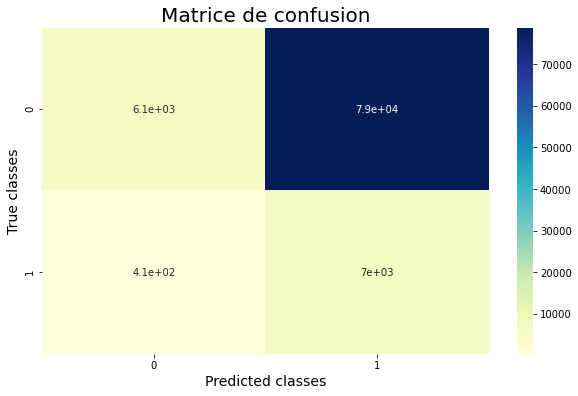

In [112]:
pred_test_sm_df = pd.DataFrame(index=X_te_std.index)
pred_test_sm_df['predicted_class'] = clf_sm.predict(X_te_std)
pred_test_sm_df['TARGET'] = tests['TARGET'].values
plt_confusion_matrix(pred_test_sm_df['TARGET'], pred_test_sm_df['predicted_class'])

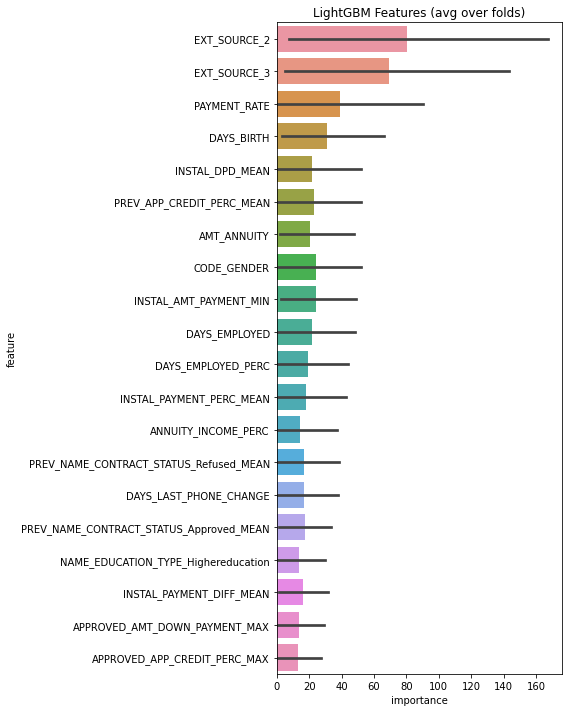

In [113]:
display_importances(feature_importance_df_ = feature_importance_df_cm_final)

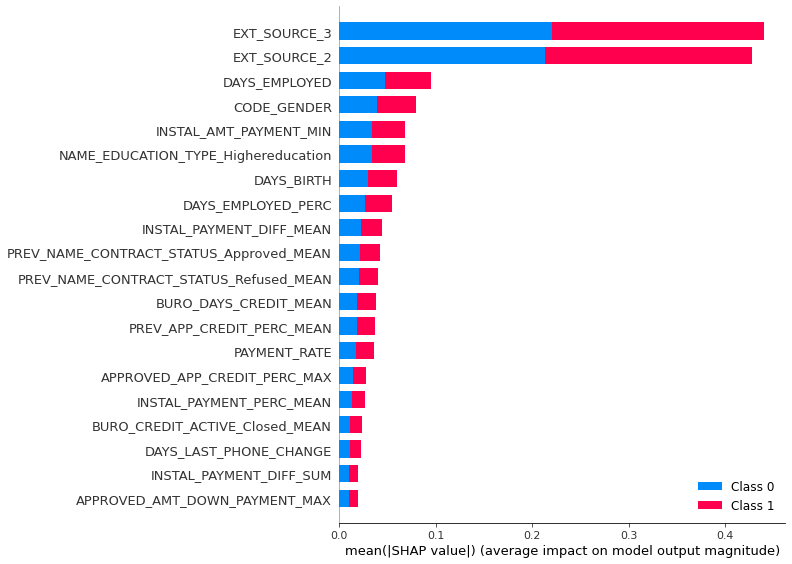

In [115]:
explainer = shap.TreeExplainer(clf_cm_final)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [116]:
from scipy.special import expit
# Conversion of shap values from log odds to probabilities
def shap_transform_scale(shap_values, expected_value, model_prediction):
    #Compute the transformed base value, which consists in applying the logit function to the base value
    expected_value_transformed = expit(expected_value)
    #Computing the original_explanation_distance to construct the distance_coefficient later on
    original_explanation_distance = sum(shap_values)
    #Computing the distance between the model_prediction and the transformed base_value
    distance_to_explain = model_prediction - expected_value_transformed
    #The distance_coefficient is the ratio between both distances which will be used later on
    distance_coefficient = original_explanation_distance / distance_to_explain
    #Transforming the original shapley values to the new scale
    shap_values_transformed = shap_values / distance_coefficient
    return shap_values_transformed, expected_value_transformed

In [117]:
explainer.expected_value[1]

-0.0010837639292589714

In [119]:
feat_imp = feature_importance_df_cm_final.groupby(by='feature',as_index =False).mean()
feat_imp = feat_imp.sort_values(by=['importance'], ascending=False)
feat_imp.drop('fold', axis=1, inplace=True)
feat_imp

,feature,importance
70,EXT_SOURCE_2,80.4
71,EXT_SOURCE_3,69.2
100,PAYMENT_RATE,39.2
63,DAYS_BIRTH,30.8
62,CODE_GENDER,24.4
...,...,...
130,PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN,0.2
12,ACTIVE_MONTHS_BALANCE_SIZE_SUM,0.2
146,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,0.0
58,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,0.0


In [123]:
not_imp = feat_imp[feat_imp['importance']<3.]['feature'].values
len(not_imp)

55

In [124]:
feat_sel = [col for col in X_train.columns if col not in not_imp]
len(feat_sel)

96

In [151]:
feat_sel_df = feat_imp[feat_imp['importance']>=3.]
feat_sel_df.to_csv('feat_sel_df.csv',index=False)

In [126]:
df_class.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
0,100002,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,0.018801,-9461.0,...,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0,1.0
1,100003,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,0.003541,-16765.0,...,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0,0.0
2,100004,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,0.010032,-19046.0,...,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0,0.0
3,100006,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,0.008019,-19005.0,...,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0,0.0
4,100007,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,0.028663,-19932.0,...,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0,0.0


In [128]:
df_class.iloc[210257,:]

SK_ID_CURR                        343662.00000
CODE_GENDER                            0.00000
FLAG_OWN_CAR                           1.00000
FLAG_OWN_REALTY                        1.00000
CNT_CHILDREN                           0.00000
                                      ...     
INSTAL_DAYS_ENTRY_PAYMENT_MAX       -497.00000
INSTAL_DAYS_ENTRY_PAYMENT_MEAN     -1605.21875
INSTAL_DAYS_ENTRY_PAYMENT_SUM     -51367.00000
INSTAL_COUNT                          32.00000
TARGET                                 0.00000
Name: 210257, Length: 554, dtype: float64

In [129]:
X_train['SK_ID_CURR'] = 0
for ind in X_train.index :
    X_train.loc[ind,'SK_ID_CURR'] = df_class.loc[ind,'SK_ID_CURR']

In [133]:
X_train.set_index('SK_ID_CURR')[feat_sel].to_csv('X_tr_feat.csv')
y_train.to_csv('y_train.csv')

In [134]:
model = clf_cm_final
model.fit(X_train.set_index('SK_ID_CURR')[feat_sel],y_train)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.54, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.54
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315


LGBMClassifier(colsample_bytree=0.9497036, feature_fraction=0.54,
               lambda_l1=3.5759468318620975, lambda_l2=1.8082901282149315,
               learning_rate=0.03, max_depth=7,
               min_child_weight=24.064465970250712,
               min_split_gain=0.06494351719359896, n_estimators=10000,
               nthread=4, num_leaves=38, objective='binary',
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

**Recuperation des probabilites**

In [136]:
pred_test_proba = pd.DataFrame(clf_cm_final.predict_proba(X_test[feat_sel]),index=X_test.index)

pred_test_target = pd.DataFrame(clf_cm_final.predict(X_test[feat_sel]),index=X_test.index)
pred_test_proba['target_predict'] = pred_test_target[0].values

In [137]:
pred_train_proba = pd.DataFrame(clf_cm_final.predict_proba(X_train[feat_sel]),index=X_train.index)

pred_train_target = pd.DataFrame(clf_cm_final.predict(X_train[feat_sel]),index=X_train.index)
pred_train_proba['target_predict'] = pred_train_target[0].values

In [138]:
train_pred = pd.concat([pred_train_proba,pred_test_proba], axis=0)
train_pred.shape

(307507, 3)

In [139]:
test_df = df[df.TARGET.isnull()]

In [140]:
test_df.drop('TARGET',axis=1,inplace=True)
test_df.shape

(48744, 553)

In [141]:
test_pred = pd.DataFrame(clf_cm_final.predict_proba(test_df[feat_sel]),index=test_df.index)

test_target = clf_cm_final.predict(test_df[feat_sel])
test_pred['target_predict'] = test_target

In [142]:
temp = train_pred.reset_index()
temp.sort_values(by=['index'],inplace=True)
temp['SK_ID_CURR']=df[df.TARGET.notnull()]['SK_ID_CURR'].values


In [143]:
train_pred = temp.set_index('index')
train_pred.head()

,0,1,target_predict,SK_ID_CURR
index,,,,
0,0.817518,0.182482,0.0,100002
1,0.994989,0.005011,0.0,100003
2,0.986108,0.013892,0.0,100004
3,0.975339,0.024661,0.0,100006
4,0.933555,0.066445,0.0,100007


In [144]:
test_pred['SK_ID_CURR'] = df[df.TARGET.isnull()]['SK_ID_CURR'].values
test_pred.head()

,0,1,target_predict,SK_ID_CURR
307507,0.957205,0.042795,0.0,100001
307508,0.874840,0.125160,0.0,100005
307509,0.989871,0.010129,0.0,100013
307510,0.977755,0.022245,0.0,100028
307511,0.868289,0.131711,0.0,100038


In [145]:
train_pred.to_csv('train_pred.csv')
test_pred.to_csv('test_pred.csv')

**Shap**

In [146]:
X_all = pd.concat([X_train[feat_sel], X_test[feat_sel]], axis=0)

In [147]:
explainer = shap.TreeExplainer(model)
shap_val_all = pd.DataFrame(explainer.shap_values(X_all)[1],
                           index = X_all.index,
                           columns=X_all.columns)
expected_value = explainer.expected_value[1]
shap_t, exp_t = shap_transform_scale(shap_val_all.iloc[-10],
                                    expected_value,
                                    model.predict_proba(X_all)[:,1][-10])
shap_val_all_trans = pd.Series(shap_t, index=X_all.columns)

In [148]:
filename = 'expected_val.pkl'
outfile = open(filename,'wb')
dump(explainer.expected_value[1], outfile)
outfile.close()

In [66]:
shap_val_all.to_csv('shap_val_all.csv')

In [149]:
shap_val_all.head()

,EXT_SOURCE_2,EXT_SOURCE_3,PAYMENT_RATE,DAYS_BIRTH,AMT_ANNUITY,INSTAL_DPD_MEAN,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,PREV_APP_CREDIT_PERC_MIN,AMT_CREDIT,...,BURO_DAYS_CREDIT_MIN,PREV_AMT_GOODS_PRICE_MIN,APPROVED_AMT_CREDIT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,INSTAL_AMT_INSTALMENT_SUM,REGION_RATING_CLIENT,CLOSED_AMT_CREDIT_SUM_SUM
210257,-0.165274,-0.321234,0.088923,0.032726,0.134854,0.037505,-0.228494,-0.022357,-0.016653,-0.118973,...,0.060209,0.006087,0.018662,-0.118616,0.034719,0.035197,-0.028310,-0.081053,-0.012269,0.011147
258380,-0.015567,0.221573,-0.311779,-0.068940,0.100648,0.106984,0.095518,0.021944,0.033978,-0.005214,...,0.041782,-0.025787,-0.036681,-0.005222,0.000252,0.043031,-0.003406,-0.019505,-0.023220,-0.012177
153038,0.452659,-0.037400,0.290271,0.202386,0.242061,-0.092468,-0.062789,0.232364,-0.071246,0.089297,...,0.074503,-0.027420,0.082071,0.097459,0.041530,0.031542,-0.016232,0.046105,0.150892,0.197703
159758,0.933836,-0.102660,0.088745,0.145318,-0.000484,0.096298,0.047701,0.033425,0.070501,0.069891,...,-0.011789,0.079698,0.074111,0.009295,0.029956,0.030239,0.031563,-0.046160,0.197097,0.020236
272271,-0.181976,-0.347132,-0.064524,-0.223549,0.187165,-0.073658,-0.098501,-0.021196,-0.064621,-0.028379,...,-0.039651,0.011634,-0.057271,0.072575,0.047446,0.024564,-0.031440,-0.026578,-0.016442,0.146467


In [114]:
shap_val_all.shape

(307507, 534)

In [115]:
temp_shap = shap_val_all.reset_index()
temp_shap.head()

,index,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_COUNT
0,210257,0.125549,-0.005667,-0.011741,-0.001267,0.009520,0.118777,0.214072,-0.321690,0.086098,...,0.000274,-0.000706,0.001447,0.000025,0.000053,-0.000216,0.0,0.000012,0.0,0.000300
1,258380,0.084694,-0.021659,-0.002534,-0.004768,0.010855,0.241218,0.213132,-0.484688,-0.183378,...,0.000227,-0.000996,0.001841,0.000062,-0.000004,0.000363,0.0,0.000012,0.0,-0.000212
2,153038,0.190143,0.011122,0.001636,-0.000886,-0.049382,0.143409,0.307167,0.010134,0.074744,...,0.000853,-0.001959,0.004778,0.000089,0.000076,-0.000068,0.0,0.000012,0.0,0.000555
3,159758,-0.062206,-0.002506,0.002930,-0.009037,-0.033268,-0.066345,0.006847,0.253544,0.074730,...,0.001042,-0.005167,0.003037,0.000028,0.000051,-0.000468,0.0,0.000043,0.0,-0.000558
4,272271,-0.108055,-0.007448,0.007403,-0.002516,0.032793,0.216156,0.206044,-0.262343,0.200187,...,0.000396,-0.000763,0.001728,-0.000017,0.000056,0.000080,0.0,0.000012,0.0,0.000947


In [116]:
temp_shap = temp_shap.sort_values(by=['index'])

In [117]:
temp_shap.head()

,index,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_COUNT
232931,0,0.061540,0.003898,0.002988,-0.007484,0.015286,-0.032717,-0.008069,0.187486,0.044817,...,-0.000048,-0.000288,0.002525,0.000062,0.000046,0.000090,0.0,0.000043,0.0,0.000427
48331,1,-0.063878,0.002806,-0.020531,0.000292,0.045879,0.289659,0.076282,-0.301946,-0.120468,...,0.000645,0.000187,0.002457,0.000089,0.000055,0.000036,0.0,0.000043,0.0,0.000537
228197,2,0.295871,-0.020857,0.008751,-0.001981,-0.020350,-0.235901,-0.422019,0.240733,-0.104466,...,0.000515,0.000172,0.003130,0.000090,0.000055,0.000071,0.0,0.000012,0.0,0.000565
103317,3,-0.127794,0.001992,0.003502,-0.000873,-0.025608,-0.154157,0.047437,0.136120,-0.065441,...,0.000238,-0.001170,0.000768,0.000084,0.000123,-0.000542,0.0,0.000006,0.0,-0.003208
306935,4,0.209503,0.011353,0.015170,-0.003754,-0.025861,-0.076697,-0.036777,-0.124412,0.092174,...,-0.000128,-0.006112,0.003706,0.000072,0.000101,0.000110,0.0,0.000043,0.0,-0.000919


In [54]:
model = clf_cm_final

X = X_train[feats]
explainer = shap.Explainer(model, X)
shap_values = explainer(X,check_additivity=False)

 98%|===================| 211887/215254 [00:21<00:00]        

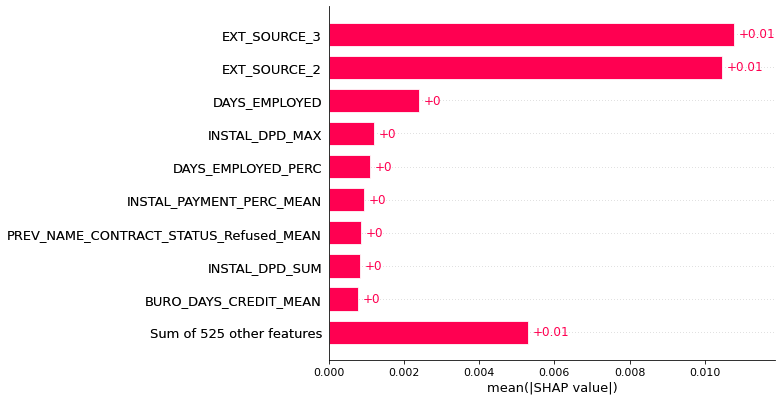

In [55]:
shap.plots.bar(shap_values)

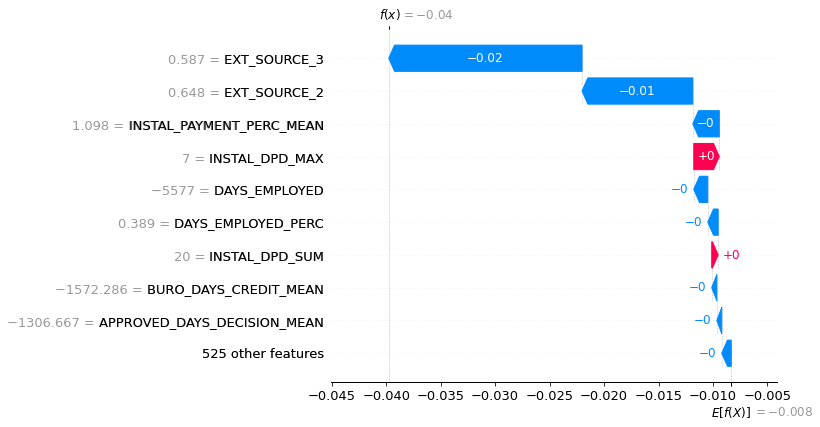

In [56]:
shap.plots.waterfall(shap_values[0])

In [57]:
feature_importance_df_cm_final.to_csv('feature_importance.csv')